In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

dataset_path = "/kaggle/input/dataset-2"
train_path = os.path.join(dataset_path, "train")
image_folder = os.path.join(train_path, "images")
label_folder = os.path.join(train_path, "labels")

image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]

if not image_files:
    print("No images found in the dataset!")
else:
   
    image_name = image_files[0]
    image_path = os.path.join(image_folder, image_name)
    label_path = os.path.join(label_folder, image_name.replace(".jpg", ".txt").replace(".png", ".txt"))

  
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  

    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Image: {image_name}")

  
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            labels = f.readlines()
        print("Label file content:")
        for line in labels:
            print(line.strip())
    else:
        print("No label file found for this image.")

    plt.show()

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt


model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")


test_image_path = "/kaggle/input/licsense-plate/test/images/00e481ea1a520175_jpg.rf.0818727629d317c7c097b6d662d0c6f9.jpg"

results = model(test_image_path)

for r in results:
    img = r.plot() 
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt") 

model.train(
    data="/kaggle/input/dataset-2/data.yaml",
    epochs=100,               # Max cap
    imgsz=640,
    patience=10,              # Stop if no improvement after 10 epochs
    name="yolov8_license_plate"
)

In [ ]:
from ultralytics import YOLO

# Load YOLOv12n model
model = YOLO("/kaggle/input/dataset-5/yolov12n.pt")

# Train with different name to avoid overwrite
model.train(
    data="/kaggle/input/dataset-5/License Plate Recognition.v4-resized640_aug3x-accurate.yolov8/data.yaml",
    epochs=10,
    imgsz=640,
    name="yolov12_license_plate"
)

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import glob

model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")

test_images_folder = "/kaggle/input/licsense-plate/test/images/"

image_paths = glob.glob(os.path.join(test_images_folder, "*.jpg"))[:100]

for img_path in image_paths:
    results = model(img_path)  

    for r in results:
        img = r.plot()  
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Detected: {os.path.basename(img_path)}")
        plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

#  Load Training Results
log_path = "/kaggle/working/runs/detect/train/results.csv"
df = pd.read_csv(log_path)

#  Display available columns for reference
print("Available columns in results.csv:", df.columns.tolist())

#  Define metric columns
precision_col = 'metrics/precision(B)'
recall_col = 'metrics/recall(B)'
map50_col = 'metrics/mAP50(B)'
map50_95_col = 'metrics/mAP50-95(B)'  # Includes stricter IoU thresholds
loss_col = 'train/box_loss'  # Bounding box regression loss
val_loss_col = 'val/box_loss'  # Validation loss

#  Fill NaN values with 0
for col in [precision_col, recall_col, map50_col, map50_95_col, loss_col, val_loss_col]:
    if col in df.columns:
        df[col] = df[col].fillna(0)

#  Compute F1-Score for each epoch
df['F1-Score'] = df.apply(
    lambda row: (2 * row[precision_col] * row[recall_col]) / (row[precision_col] + row[recall_col])
    if (row[precision_col] + row[recall_col]) > 0 else 0, axis=1
)

#  Compute Average Metrics Over All Epochs
avg_metrics = {
    "Average Precision (mAP50)": df[map50_col].mean(),
    "Average Precision (mAP50-95)": df[map50_95_col].mean(),
    "Average Precision": df[precision_col].mean(),
    "Average Recall": df[recall_col].mean(),
    "Average F1-Score": df['F1-Score'].mean(),
    "Average Train Loss": df[loss_col].mean(),
    "Average Validation Loss": df[val_loss_col].mean()
}

#  Display Summary
display(HTML("<h3>📊 Model Performance Summary</h3>"))
for metric, value in avg_metrics.items():
    display(HTML(f"<p><b>{metric}:</b> {value:.4f}</p>"))

#  Plot Performance Over Epochs
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# 🔹 (1) Precision, Recall, and F1-Score Over Epochs
axes[0].plot(df['epoch'], df['F1-Score'], label="F1-score", marker="o", linestyle="-", color="b")
axes[0].plot(df['epoch'], df[precision_col], label="Precision", marker="s", linestyle="--", color="g")
axes[0].plot(df['epoch'], df[recall_col], label="Recall", marker="d", linestyle="-.", color="r")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Score")
axes[0].set_title("🔹 Precision, Recall & F1-Score Over Epochs")
axes[0].legend()
axes[0].grid()

#  (2) mAP & Loss Over Epochs
axes[1].plot(df['epoch'], df[map50_col], label="mAP50", marker="o", linestyle="-", color="c")
axes[1].plot(df['epoch'], df[map50_95_col], label="mAP50-95", marker="s", linestyle="--", color="m")
axes[1].plot(df['epoch'], df[loss_col], label="Train Loss", marker="d", linestyle="-.", color="orange")
axes[1].plot(df['epoch'], df[val_loss_col], label="Validation Loss", marker="x", linestyle="--", color="red")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Score / Loss")
axes[1].set_title("🔹 mAP & Loss Over Epochs")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


In [ ]:
!pip install ultralytics


In [ ]:
!apt-get update
!apt-get install -y tesseract-ocr


In [ ]:
!pip install easyocr


In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import glob

# Load the trained model (adjust path if needed)
model = YOLO("/kaggle/working/runs/detect/yolov12_license_plate/weights/best.pt")

# Path to your test images
test_images_folder = "/kaggle/input/dataset-5/License Plate Recognition.v4-resized640_aug3x-accurate.yolov8/test/images"

# Load image paths (first 100 images)
image_paths = glob.glob(os.path.join(test_images_folder, "*.jpg"))[:100]

# Run inference and show results
for img_path in image_paths:
    results = model(img_path)

    for r in results:
        img = r.plot()
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Detected: {os.path.basename(img_path)}")
        plt.show()

In [ ]:
import cv2
import torch
import easyocr
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
from glob import glob

# Load YOLOv8 license plate detection model
model = YOLO("/kaggle/working/runs/detect/yolov12_license_plate/weights/best.pt")

# Set path to folder containing images/kaggle/input/dataset-5/License Plate Recognition.v4-resized640_aug3x-accurate.yolov8/test/images
image_folder = "/kaggle/input/dataset-5/License Plate Recognition.v4-resized640_aug3x-accurate.yolov8/test/images"

# Get list of image files
image_paths = glob(os.path.join(image_folder, "*.jpg"))  # you can add "*.png" if needed

# Initialize EasyOCR
reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())

# Process each image in the folder
for image_path in image_paths:
    print(f"\n📷 Processing: {os.path.basename(image_path)}")
    image = cv2.imread(image_path)
    image = cv2.resize(image, (640, 480))

    results = model(image)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Add padding
            pad = 10
            x1, y1 = max(0, x1 - pad), max(0, y1 - pad)
            x2, y2 = min(image.shape[1], x2 + pad), min(image.shape[0], y2 + pad)

            # Crop plate region
            plate_image = image[y1:y2, x1:x2]

            # Show cropped plate
            plt.figure(figsize=(6, 3))
            plt.imshow(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB))
            plt.title("Detected License Plate")
            plt.axis("off")
            plt.show()

            # OCR
            ocr_result = reader.readtext(plate_image)

            if ocr_result:
                plate_text = ' '.join([res[1] for res in ocr_result])
                print("🔍 Detected License Plate Number:", plate_text)

                # Draw on original image
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(image, plate_text, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
            else:
                print("❌ No text detected")

    # Show final result
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Final Result: {os.path.basename(image_path)}")
    plt.axis("off")
    plt.show()



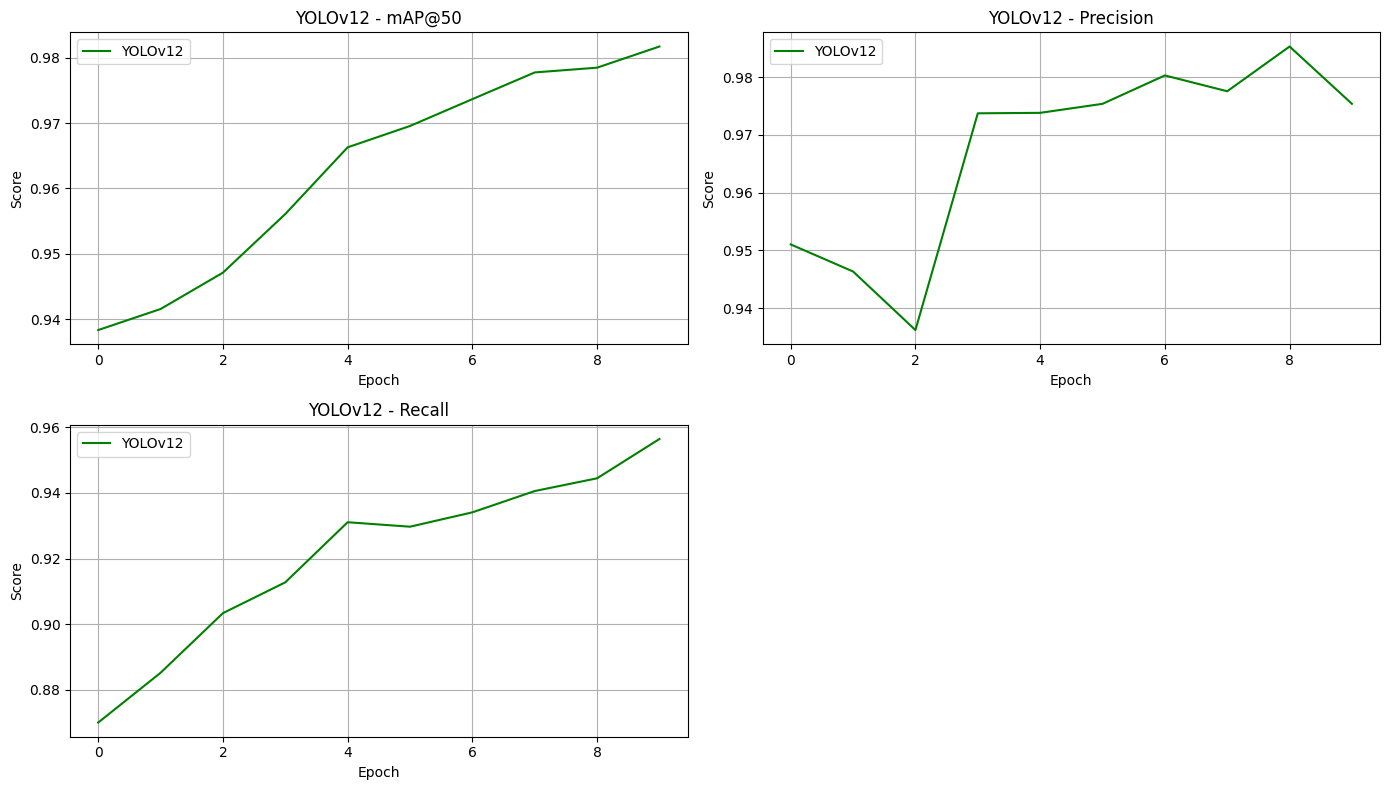

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load YOLOv12 results
yolo12_path = "/kaggle/working/runs/detect/yolov12_license_plate/results.csv"
df12 = pd.read_csv(yolo12_path)

# Plotting for YOLOv12
plt.figure(figsize=(14, 8))

# mAP50
plt.subplot(2, 2, 1)
plt.plot(df12["metrics/mAP50(B)"], label="YOLOv12", color="green")
plt.title("YOLOv12 - mAP@50")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(df12["metrics/precision(B)"], label="YOLOv12", color="green")
plt.title("YOLOv12 - Precision")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(df12["metrics/recall(B)"], label="YOLOv12", color="green")
plt.title("YOLOv12 - Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
!pip install easyocr

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract